<a href="https://colab.research.google.com/github/Masciel-Sevilla/modelos/blob/main/Small-Pro-V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Paso 1: Descomprimir el dataset (esto solo se hace una vez)
import os
import zipfile

zip_path = '/content/Balanced.zip'
extract_path = '/content/'

# Solo descomprimir si no se ha hecho antes
if not os.path.exists(os.path.join(extract_path, 'Balanced')):
    print(f"Descomprimiendo {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("¡Descompresión completada!")
else:
    print("La carpeta 'Balanced' ya existe. Omitiendo descompresión.")

Descomprimiendo /content/Balanced.zip...
¡Descompresión completada!


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

# --- Configuración del modelo ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 6   # 0-background, 1-Cow-tongue, 2-Dandelion, 3-Kikuyo, 4-Other, 5-Potato
BATCH_SIZE = 16
EPOCHS = 150
LEARNING_RATE = 1e-4

# --- Paths ---
# Asegúrate de que estas rutas coincidan con la estructura de tus carpetas
BASE_PATH = './Balanced'
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, 'train/images')
TRAIN_MASKS_PATH = os.path.join(BASE_PATH, 'train/masks')
VAL_IMAGES_PATH = os.path.join(BASE_PATH, 'val/images')
VAL_MASKS_PATH = os.path.join(BASE_PATH, 'val/masks')
# NUEVO: Paths para el conjunto de test, como lo pide tu tarea
TEST_IMAGES_PATH = os.path.join(BASE_PATH, 'test/images')
TEST_MASKS_PATH = os.path.join(BASE_PATH, 'test/masks')


# --- Módulos del modelo (ASPP, DeformableAttention) ---
class ASPPModule(layers.Layer):
    def __init__(self, filters=192, **kwargs):
        super(ASPPModule, self).__init__(**kwargs)
        self.filters = filters
        self.conv_1x1 = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1 = layers.BatchNormalization()
        self.relu_1x1 = layers.ReLU()
        self.conv_3x3_6 = layers.Conv2D(filters, 3, padding='same', dilation_rate=6, use_bias=False)
        self.bn_3x3_6 = layers.BatchNormalization()
        self.relu_3x3_6 = layers.ReLU()
        self.conv_3x3_12 = layers.Conv2D(filters, 3, padding='same', dilation_rate=12, use_bias=False)
        self.bn_3x3_12 = layers.BatchNormalization()
        self.relu_3x3_12 = layers.ReLU()
        self.conv_3x3_18 = layers.Conv2D(filters, 3, padding='same', dilation_rate=18, use_bias=False)
        self.bn_3x3_18 = layers.BatchNormalization()
        self.relu_3x3_18 = layers.ReLU()
        self.global_avg_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.conv_1x1_gap = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1_gap = layers.BatchNormalization()
        self.relu_1x1_gap = layers.ReLU()
        self.conv_final = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_final = layers.BatchNormalization()
        self.relu_final = layers.ReLU()
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs, training=None):
        input_shape = tf.shape(inputs)
        conv_1x1 = self.relu_1x1(self.bn_1x1(self.conv_1x1(inputs), training=training))
        conv_3x3_6 = self.relu_3x3_6(self.bn_3x3_6(self.conv_3x3_6(inputs), training=training))
        conv_3x3_12 = self.relu_3x3_12(self.bn_3x3_12(self.conv_3x3_12(inputs), training=training))
        conv_3x3_18 = self.relu_3x3_18(self.bn_3x3_18(self.conv_3x3_18(inputs), training=training))
        gap = self.global_avg_pool(inputs)
        gap = self.relu_1x1_gap(self.bn_1x1_gap(self.conv_1x1_gap(gap), training=training))
        gap = tf.image.resize(gap, [input_shape[1], input_shape[2]], method='bilinear')
        concat = layers.Concatenate()([conv_1x1, conv_3x3_6, conv_3x3_12, conv_3x3_18, gap])
        output = self.relu_final(self.bn_final(self.conv_final(concat), training=training))
        output = self.dropout(output, training=training)
        return output

class DeformableAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(DeformableAttention, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.attention_conv = layers.Conv2D(self.filters, 1, padding='same', activation='sigmoid', name='attention_weights_conv', use_bias=False)
        self.bn_attention = layers.BatchNormalization()
        self.feature_conv = layers.SeparableConv2D(self.filters, 3, padding='same', name='feature_processing_conv', use_bias=False)
        self.bn_feature = layers.BatchNormalization()
        self.relu_feature = layers.ReLU()
        super(DeformableAttention, self).build(input_shape)

    def call(self, inputs, training=None):
        attention_weights = self.bn_attention(self.attention_conv(inputs), training=training)
        features = self.relu_feature(self.bn_feature(self.feature_conv(inputs), training=training))
        attended_features = features * attention_weights
        return attended_features

# --- Backbone y Arquitectura del Modelo ---
def create_efficient_backbone(input_shape):
    """Crea el backbone usando EfficientNetV2S y extrae los mapas de características."""
    base_model = tf.keras.applications.EfficientNetV2S(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    base_model.trainable = True
    layer_names = [
        'block1a_project_activation',
        'block2c_add',
        'block3c_add',
        'block6a_expand_activation',
        'top_activation'
    ]
    outputs = [base_model.get_layer(name).output for name in layer_names]
    return Model(inputs=base_model.input, outputs=outputs, name='EfficientNetV2S_Backbone')

def create_weed_detection_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    backbone = create_efficient_backbone(input_shape)
    feat1_out, feat2_out, feat3_out, feat4_out, feat5_out = backbone(inputs)
    deep_features = feat5_out
    aspp_filters = 192
    aspp_features = ASPPModule(filters=aspp_filters)(deep_features)
    attended_features = DeformableAttention(filters=aspp_filters)(aspp_features)
    decoder_up1 = layers.Conv2DTranspose(96, 2, strides=2, padding='same', use_bias=False)(attended_features)
    decoder_up1 = layers.BatchNormalization()(decoder_up1)
    decoder_up1 = layers.ReLU()(decoder_up1)
    decoder_up1 = layers.Dropout(0.2)(decoder_up1)
    feat4_processed = layers.Conv2D(96, 1, padding='same', use_bias=False)(feat4_out)
    feat4_processed = layers.BatchNormalization()(feat4_processed)
    feat4_processed = layers.ReLU()(feat4_processed)
    decoder_concat_8x8 = layers.Concatenate()([decoder_up1, feat4_processed])
    decoder_conv_8x8 = layers.SeparableConv2D(96, 3, padding='same', use_bias=False)(decoder_concat_8x8)
    decoder_conv_8x8 = layers.BatchNormalization()(decoder_conv_8x8)
    decoder_conv_8x8 = layers.ReLU()(decoder_conv_8x8)
    decoder_conv_8x8 = layers.Dropout(0.2)(decoder_conv_8x8)
    decoder_up2 = layers.Conv2DTranspose(96, 2, strides=2, padding='same', use_bias=False)(decoder_conv_8x8)
    decoder_up2 = layers.BatchNormalization()(decoder_up2)
    decoder_up2 = layers.ReLU()(decoder_up2)
    decoder_up2 = layers.Dropout(0.2)(decoder_up2)
    feat3_processed = layers.Conv2D(96, 1, padding='same', use_bias=False)(feat3_out)
    feat3_processed = layers.BatchNormalization()(feat3_processed)
    feat3_processed = layers.ReLU()(feat3_processed)
    decoder_concat_16x16 = layers.Concatenate()([decoder_up2, feat3_processed])
    decoder_conv_16x16 = layers.SeparableConv2D(96, 3, padding='same', use_bias=False)(decoder_concat_16x16)
    decoder_conv_16x16 = layers.BatchNormalization()(decoder_conv_16x16)
    decoder_conv_16x16 = layers.ReLU()(decoder_conv_16x16)
    decoder_conv_16x16 = layers.Dropout(0.2)(decoder_conv_16x16)
    decoder_up3 = layers.Conv2DTranspose(48, 2, strides=2, padding='same', use_bias=False)(decoder_conv_16x16)
    decoder_up3 = layers.BatchNormalization()(decoder_up3)
    decoder_up3 = layers.ReLU()(decoder_up3)
    decoder_up3 = layers.Dropout(0.2)(decoder_up3)
    feat2_processed = layers.Conv2D(48, 1, padding='same', use_bias=False)(feat2_out)
    feat2_processed = layers.BatchNormalization()(feat2_processed)
    feat2_processed = layers.ReLU()(feat2_processed)
    decoder_concat_32x32 = layers.Concatenate()([decoder_up3, feat2_processed])
    decoder_conv_32x32 = layers.SeparableConv2D(48, 3, padding='same', use_bias=False)(decoder_concat_32x32)
    decoder_conv_32x32 = layers.BatchNormalization()(decoder_conv_32x32)
    decoder_conv_32x32 = layers.ReLU()(decoder_conv_32x32)
    decoder_conv_32x32 = layers.Dropout(0.2)(decoder_conv_32x32)
    decoder_up4 = layers.Conv2DTranspose(24, 2, strides=2, padding='same', use_bias=False)(decoder_conv_32x32)
    decoder_up4 = layers.BatchNormalization()(decoder_up4)
    decoder_up4 = layers.ReLU()(decoder_up4)
    decoder_up4 = layers.Dropout(0.2)(decoder_up4)
    feat1_processed = layers.Conv2D(24, 1, padding='same', use_bias=False)(feat1_out)
    feat1_processed = layers.BatchNormalization()(feat1_processed)
    feat1_processed = layers.ReLU()(feat1_processed)
    decoder_concat_64x64 = layers.Concatenate()([decoder_up4, feat1_processed])
    decoder_conv_64x64 = layers.SeparableConv2D(24, 3, padding='same', use_bias=False)(decoder_concat_64x64)
    decoder_conv_64x64 = layers.BatchNormalization()(decoder_conv_64x64)
    decoder_conv_64x64 = layers.ReLU()(decoder_conv_64x64)
    decoder_conv_64x64 = layers.Dropout(0.2)(decoder_conv_64x64)
    outputs = layers.Conv2DTranspose(NUM_CLASSES, 2, strides=2, padding='same', use_bias=False)(decoder_conv_64x64)
    outputs = layers.Conv2D(NUM_CLASSES, 1, padding='same', activation='softmax', name='segmentation_output')(outputs)
    model = Model(inputs=inputs, outputs=outputs, name='EfficientWeedDetectionModel_S')
    return model

# --- Métricas y Funciones de Pérdida ---
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1, NUM_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    dice_scores = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0) + smooth)
    return tf.reduce_mean(dice_scores)

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return loss
    return focal_loss_fixed

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    class_weights = tf.constant([0.4, 4.0, 3.5, 1.0, 2.0, 4.0])
    f_loss_per_pixel_per_class = focal_loss(gamma=2.0, alpha=0.75)(y_true, y_pred)
    weighted_f_loss = f_loss_per_pixel_per_class * class_weights
    f_loss_reduced = tf.reduce_sum(weighted_f_loss, axis=-1)
    f_loss_mean = tf.reduce_mean(f_loss_reduced)
    d_loss = dice_loss(y_true, y_pred)
    return f_loss_mean + (1.5 * d_loss)

# La métrica 'accuracy' es la global accuracy.
# Para mIoU, usaremos iou_metric que es un buen proxy (Mean IoU).
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=NUM_CLASSES)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.where(tf.equal(union, 0), 1.0, intersection / union)
    return tf.reduce_mean(iou)

def iou_per_class(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=NUM_CLASSES)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection
    iou = tf.where(tf.equal(union, 0), 1.0, intersection / union)
    return tf.reduce_mean(iou, axis=0)

# --- Carga y Preprocesamiento de Datos ---
def load_and_preprocess_data(image_paths, mask_paths, augment=False):
    def load_image_only(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image.set_shape([None, None, 3])
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bilinear')
        return tf.cast(image, tf.float32)

    def load_mask_only(mask_path):
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
        mask = tf.cast(mask, tf.int32)
        mask = tf.squeeze(mask, axis=-1)
        mask = tf.one_hot(mask, NUM_CLASSES)
        return mask

    def augment_and_preprocess(image, mask):
        if tf.random.uniform([]) > 0.5: image, mask = tf.image.flip_left_right(image), tf.image.flip_left_right(mask)
        if tf.random.uniform([]) > 0.5: image, mask = tf.image.flip_up_down(image), tf.image.flip_up_down(mask)
        if tf.random.uniform([]) > 0.5: k = tf.random.uniform([], 1, 4, dtype=tf.int32); image, mask = tf.image.rot90(image, k), tf.image.rot90(mask, k)
        image = tf.image.random_brightness(image, max_delta=0.4 * 255)
        image = tf.image.random_contrast(image, lower=0.6, upper=1.4)
        image = tf.image.random_hue(image, max_delta=0.15)
        image = tf.image.random_saturation(image, lower=0.6, upper=1.4)
        image = tf.clip_by_value(image, 0.0, 255.0)
        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
        return image, mask

    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(load_image_only, num_parallel_calls=tf.data.AUTOTUNE)
    mask_ds = tf.data.Dataset.from_tensor_slices(mask_paths).map(load_mask_only, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = tf.data.Dataset.zip((image_ds, mask_ds))

    if augment:
        dataset = dataset.shuffle(buffer_size=1000).map(augment_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(lambda img, mask: (tf.keras.applications.efficientnet_v2.preprocess_input(img), mask), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

def train_model(train_dataset, val_dataset, model_save_path='efficient_weed_model_S.keras'):
    model = create_weed_detection_model()
    model.summary()
    optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-5)

    # Aquí ya estás pidiendo las métricas correctas
    model.compile(
        optimizer=optimizer,
        loss=combined_loss,
        metrics=[dice_coefficient, iou_metric, 'accuracy'] # accuracy es global accuracy
    )
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(model_save_path, monitor='val_iou_metric', save_best_only=True, mode='max', verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_iou_metric', patience=50, mode='max', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=20, min_lr=1e-7, verbose=1),
    ]
    print(f"Iniciando entrenamiento por {EPOCHS} épocas...")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    )
    return model, history


# --- Bloque de Ejecución Principal ---
if __name__ == "__main__":
    # 1. Cargar datos de entrenamiento y validación
    train_image_paths = sorted(glob(os.path.join(TRAIN_IMAGES_PATH, '*.jpg')))
    train_mask_paths = sorted(glob(os.path.join(TRAIN_MASKS_PATH, '*.png')))
    val_image_paths = sorted(glob(os.path.join(VAL_IMAGES_PATH, '*.jpg')))
    val_mask_paths = sorted(glob(os.path.join(VAL_MASKS_PATH, '*.png')))

    print("Creando datasets de entrenamiento y validación...")
    train_ds = load_and_preprocess_data(train_image_paths, train_mask_paths, augment=True)
    val_ds = load_and_preprocess_data(val_image_paths, val_mask_paths, augment=False)

    # 2. Entrenar el modelo
    model_save_path = 'efficient_weed_model_S_best.keras'
    model, history = train_model(train_ds, val_ds, model_save_path=model_save_path)

    print("\n--- Entrenamiento Finalizado ---")
    print(f"El mejor modelo se ha guardado en: {model_save_path}")

    # 3. Cargar el MEJOR modelo guardado para la evaluación final
    print("\nCargando el mejor modelo guardado para la evaluación en el conjunto de test...")
    best_model = tf.keras.models.load_model(
        model_save_path,
        custom_objects={
            'ASPPModule': ASPPModule,
            'DeformableAttention': DeformableAttention,
            'combined_loss': combined_loss,
            'dice_coefficient': dice_coefficient,
            'iou_metric': iou_metric,
            'dice_loss': dice_loss # Añadido por si acaso es necesario
        }
    )

    # 4. Cargar datos de test
    test_image_paths = sorted(glob(os.path.join(TEST_IMAGES_PATH, '*.jpg')))
    test_mask_paths = sorted(glob(os.path.join(TEST_MASKS_PATH, '*.png')))

    if not test_image_paths:
        print("\nADVERTENCIA: No se encontraron imágenes en el directorio de test. Saltando la evaluación de test.")
    else:
        print(f"Se encontraron {len(test_image_paths)} imágenes de test.")
        print("Creando dataset de test...")
        test_ds = load_and_preprocess_data(test_image_paths, test_mask_paths, augment=False)

        # 5. Evaluar en el conjunto de TEST
        print("\n--- EVALUACIÓN FINAL EN EL CONJUNTO DE TEST ---")
        test_metrics = best_model.evaluate(test_ds)

        print("\n## MÉTRICAS DE TEST - MODELO 'SMALL' ##")
        print(f"Test Loss: {test_metrics[0]:.4f}")
        print(f"Test Dice Coefficient: {test_metrics[1]:.4f}")
        print(f"Test mIoU: {test_metrics[2]:.4f}")
        print(f"Test Global Accuracy: {test_metrics[3]:.4f}")

        # Calcular IoU por clase en el conjunto de test
        print("\nCalculando IoU por clase en el conjunto de test...")
        iou_per_class_values = []
        for images_batch, masks_batch in test_ds:
            predictions_batch = best_model.predict(images_batch, verbose=0)
            iou_per_class_values.append(iou_per_class(masks_batch, predictions_batch))

        iou_per_class_values = tf.reduce_mean(tf.stack(iou_per_class_values), axis=0).numpy()
        class_names = ['Background', 'Cow-tongue', 'Dandelion', 'Kikuyo', 'Other', 'Potato']
        print("\n## IoU por Clase (Test) ##")
        for i, iou in enumerate(iou_per_class_values):
            print(f"IoU for {class_names[i]}: {iou:.4f}")

Creando datasets de entrenamiento y validación...
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "EfficientWeedDetectionModel_S"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EfficientNetV2S_Ba… │ [(None, 64, 64,   │ 20,331,360 │ input_layer[0][0] │
│ (Functional)        │ 24), (None, 32,   │            │                   │
│                     │ 32, 48), (None,   │            │                   │
│                     │ 16, 16, 64),      │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 960), (None, 4,   │            │                   │
│                     │ 4, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspp_module         │ (None, 4, 4, 192) │  7,315,968 │ EfficientNetV2S_… │
│ (ASPPModule)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deformable_attenti… │ (None, 4, 4, 192) │     76,992 │ aspp_module[0][0] │
│ (DeformableAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 96)  │     73,728 │ deformable_atten… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 96)  │        384 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 96)  │     92,160 │ EfficientNetV2S_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 8, 8, 96)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 96)  │        384 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 96)  │          0 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 8, 8, 96)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8, 192) │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ re_lu_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 8, 8, 96)  │     20,160 │ concatenate_2[0]… │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 96)  │        384 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 8, 8, 96)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 96)  │          0 │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │     36,864 │ dropout_2[0][0]   │
│ (Conv2DTranspose)   │ 96)               │            │                 

 Total params: 28,010,298 (106.85 MB)

 Trainable params: 27,851,770 (106.25 MB)

 Non-trainable params: 158,528 (619.25 KB)

Iniciando entrenamiento por 150 épocas...
Epoch 1/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1018 - dice_coefficient: 0.0833 - iou_metric: 0.0539 - loss: 2.3735
Epoch 1: val_iou_metric improved from -inf to 0.11546, saving model to efficient_weed_model_S_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 221s 315ms/step - accuracy: 0.1019 - dice_coefficient: 0.0833 - iou_metric: 0.0540 - loss: 2.3730 - val_accuracy: 0.2080 - val_dice_coefficient: 0.0862 - val_iou_metric: 0.1155 - val_loss: 2.2141 - learning_rate: 1.0000e-04
Epoch 2/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1793 - dice_coefficient: 0.0937 - iou_metric: 0.1015 - loss: 2.1782
Epoch 2: val_iou_metric improved from 0.11546 to 0.20706, saving model to efficient_weed_model_S_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.1796 - dice_coefficient: 0.0937 - iou_metric: 0.1017 - loss: 2.1777 - val_accuracy: 0.3436 - val_dice_coefficient: 0.0907 - val_iou_metric: 0.2071 - val_loss: 2.1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'aspp_module', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Se encontraron 210 imágenes de test.
Creando dataset de test...

--- EVALUACIÓN FINAL EN EL CONJUNTO DE TEST ---
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 465ms/step - accuracy: 0.9668 - dice_coefficient: 0.7174 - iou_metric: 0.9372 - loss: 0.5342

## MÉTRICAS DE TEST - MODELO 'SMALL' ##
Test Loss: 0.4899
Test Dice Coefficient: 0.7210
Test mIoU: 0.9419
Test Global Accuracy: 0.9698

Calculando IoU por clase en el conjunto de test...

## IoU por Clase (Test) ##
IoU for Background: 0.9571
IoU for Cow-tongue: 0.9093
IoU for Dandelion: 0.9133
IoU for Kikuyo: 0.9125
IoU for Other: 0.7227
IoU for Potato: 0.9079


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


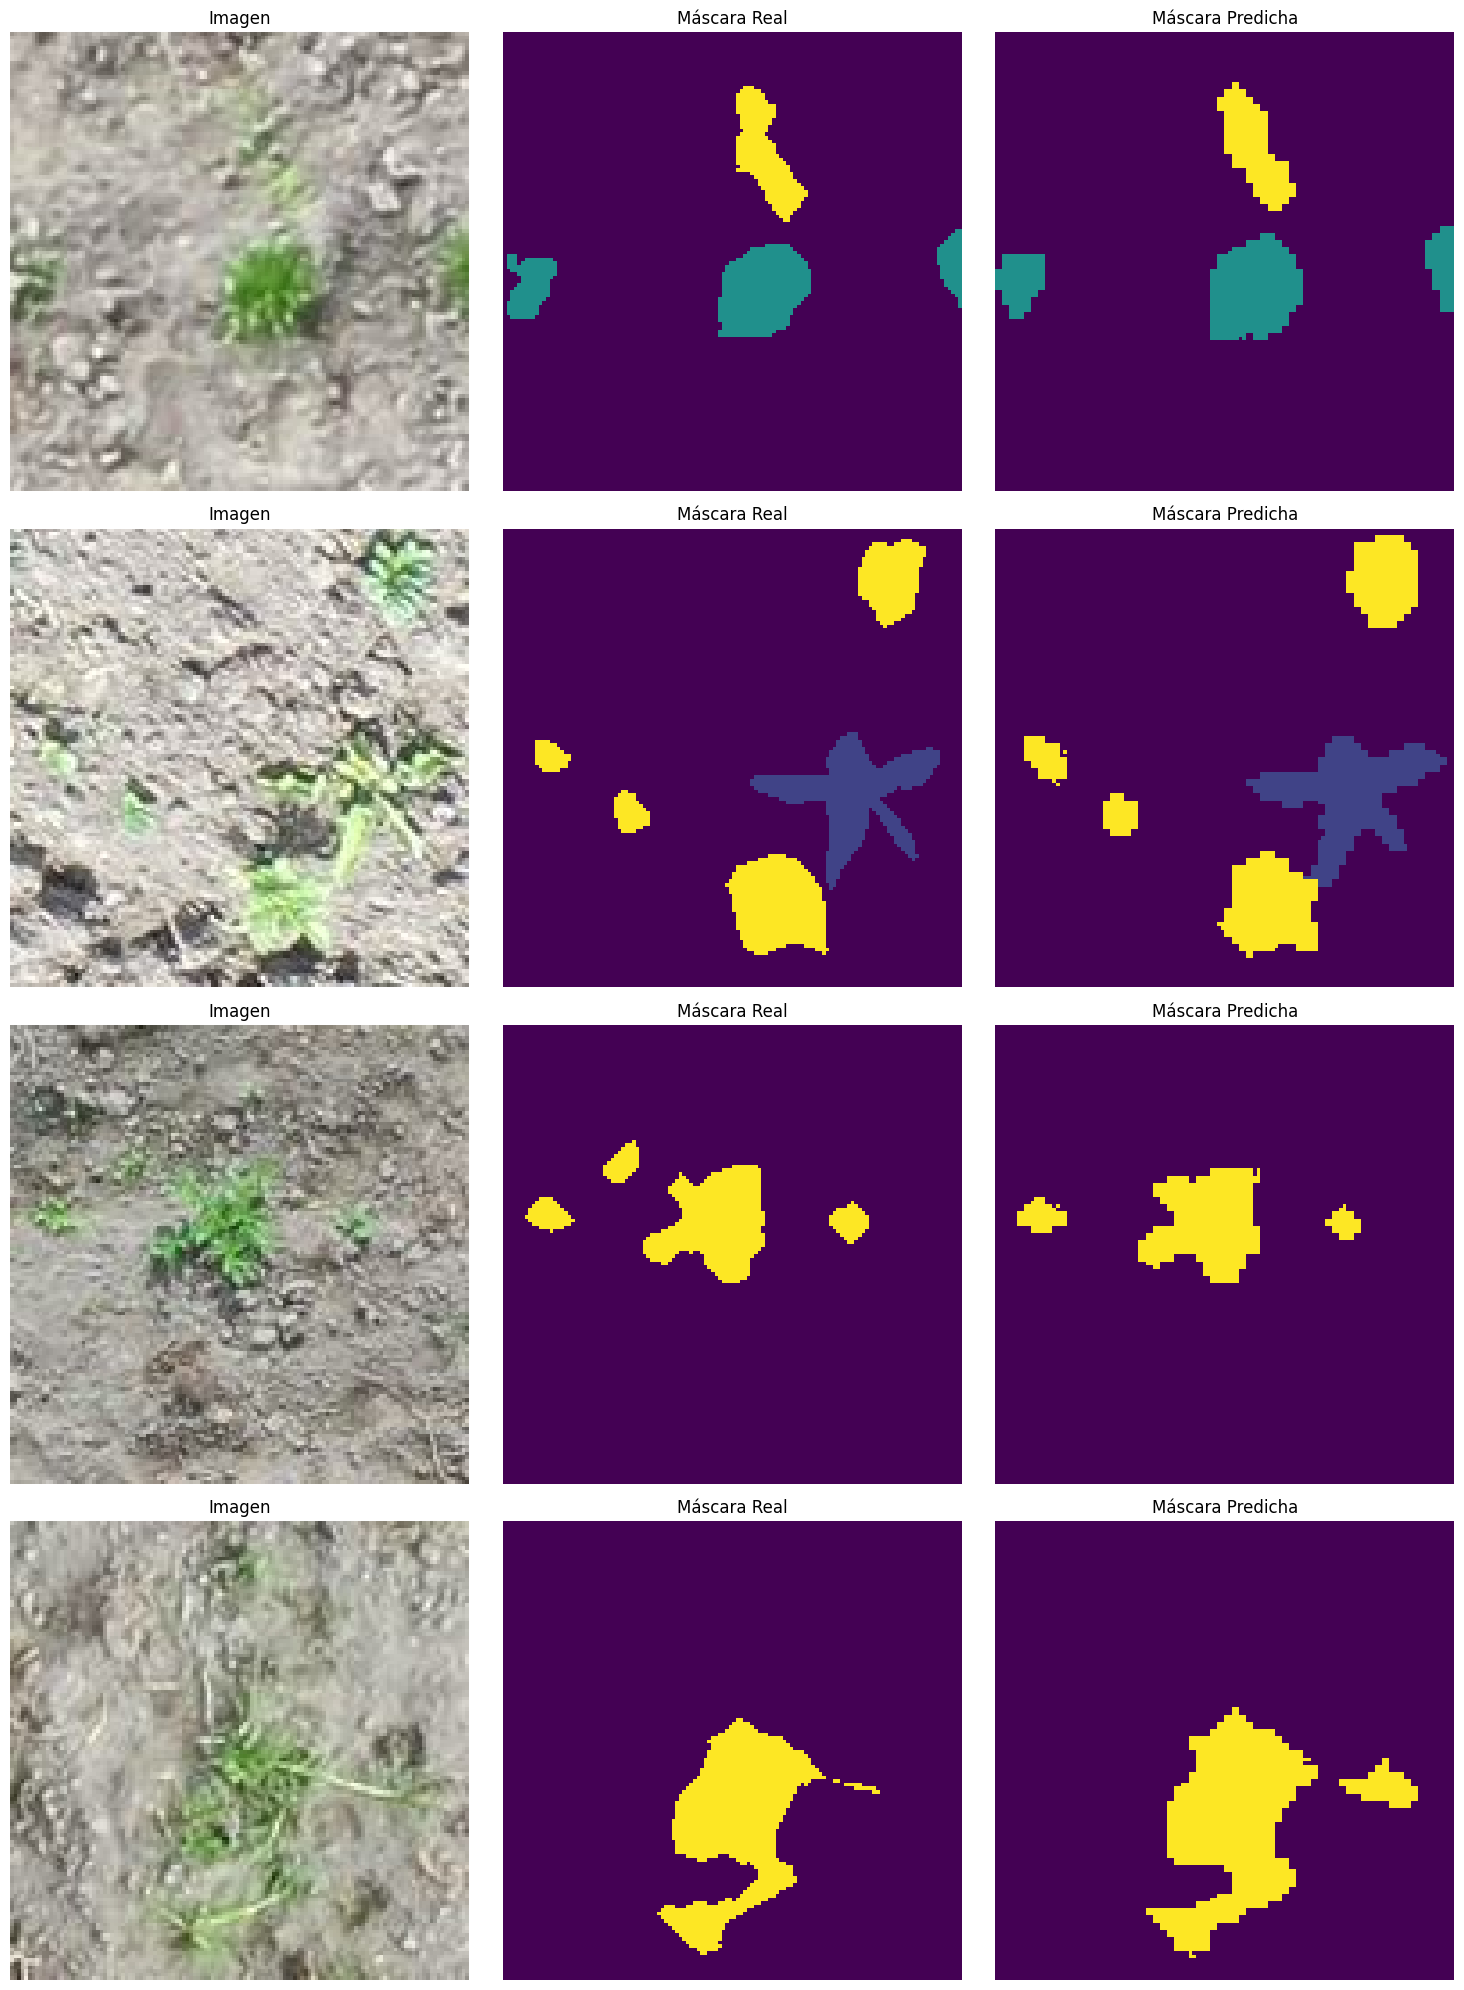

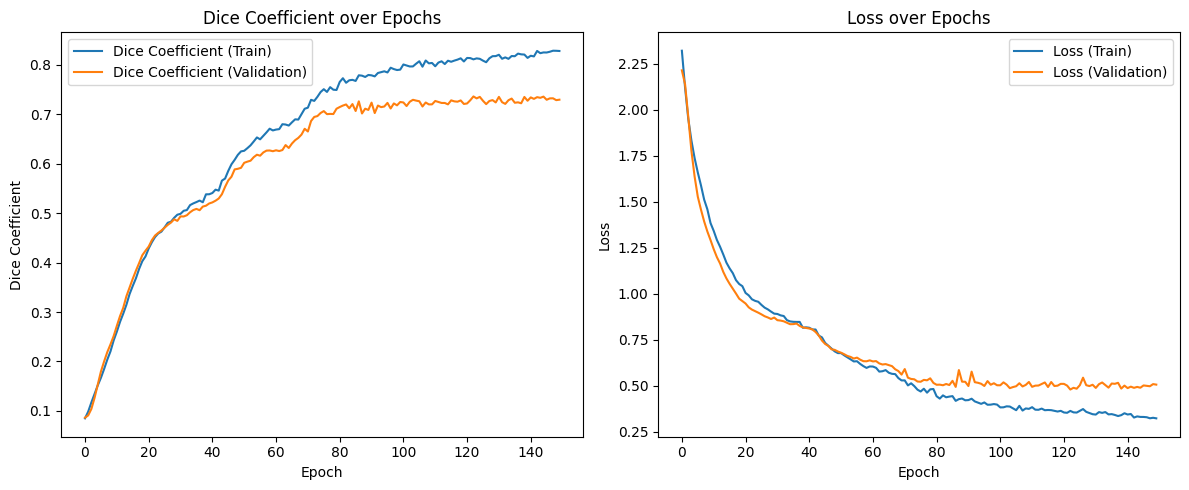

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar ejemplos de máscaras reales y predichas
def plot_sample_masks(images, masks, predictions, num_samples=4):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Imagen
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title("Imagen")
        plt.axis('off')

        # Máscara real
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(tf.argmax(masks[i], axis=-1))
        plt.title("Máscara Real")
        plt.axis('off')

        # Máscara predicha
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(tf.argmax(predictions[i], axis=-1))
        plt.title("Máscara Predicha")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Obtener todos los lotes de datos del conjunto de test
all_test_images = []
all_test_masks = []
for images_batch, masks_batch in test_ds:
    all_test_images.append(images_batch.numpy())
    all_test_masks.append(masks_batch.numpy())

# Convertir a listas de numpy para facilitar la selección aleatoria
all_test_images = np.concatenate(all_test_images, axis=0)
all_test_masks = np.concatenate(all_test_masks, axis=0)

# Seleccionar índices aleatorios
num_samples = 4
random_indices = np.random.choice(len(all_test_images), num_samples, replace=False)

# Obtener las imágenes y máscaras correspondientes a los índices aleatorios
random_images = all_test_images[random_indices]
random_masks = all_test_masks[random_indices]

# Predecir las máscaras para las imágenes seleccionadas
predictions_batch = best_model.predict(random_images)

# Mostrar ejemplos de máscaras reales y predichas
plot_sample_masks(random_images, random_masks, predictions_batch)

# Gráficas de Dice Coefficient y Loss durante el entrenamiento
plt.figure(figsize=(12, 5))

# Gráfica de Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Dice Coefficient (Train)')
plt.plot(history.history['val_dice_coefficient'], label='Dice Coefficient (Validation)')
plt.title('Dice Coefficient over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

# Gráfica de Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
